In [1]:
import json
import numpy as np
import math
from tabulate import tabulate

In [2]:
def compute_distance(bbox1, bbox2):
    midx1 = bbox1[0] + bbox1[2]
    midy1 = bbox1[1] + bbox1[3]
    midx2 = bbox2[0] + bbox2[2]
    midy2 = bbox2[1] + bbox2[3]

    # return np.linalg.norm(np.array([midx1, midy1]) - 
    #                       np.array([midx2, midy2]))

    return math.dist([midx1, midy1], [midx2, midy2])


In [18]:
def get_dis(gt, max_score, cls_id):
    dis = []
    img = set()
    test_ids = [i['id'] for i in gt['images']]
    # print(len(test_ids))
    for test_id in test_ids:
        if test_id == 4146631:
            continue
        if (test_id, cls_id) not in max_score.keys():
            continue
        for ann in gt['annotations']:
            if ann['image_id'] == test_id and ann['category_id'] == cls_id:
                if test_id == 2946054 and ann['id'] == 5689277: ## manually skip wrong label
                    continue
                if test_id in img:
                    # print(ann)
                    continue
                gt_bbox = ann['bbox']
                pd_bbox = max_score[(test_id, cls_id)][0]['bbox']
                d = compute_distance(gt_bbox, pd_bbox)
                dis.append(d)
                img.add(test_id)
                
    return dis


In [69]:
# for ann in gt['annotations']:
#     if ann['image_id'] == 2946054:
#         print(ann)

{'id': 5689280, 'image_id': 2946054, 'category_id': 3048, 'job_id': 278814, 'assignee': 'linhaiht@gmail.com', 'segmentation': [], 'bbox': [498.05317408100404, 272.2052343069171, 128.03244641823193, 158.93683003642556], 'iscrowd': 0, 'area': 20349.07117552229}
{'id': 5689279, 'image_id': 2946054, 'category_id': 3048, 'job_id': 278814, 'assignee': 'linhaiht@gmail.com', 'segmentation': [], 'bbox': [701.8804406961924, 256.89961274990964, 141.63134541682666, 183.15522332798824], 'iscrowd': 0, 'area': 25940.52070006233}
{'id': 5689278, 'image_id': 2946054, 'category_id': 3046, 'job_id': 278814, 'assignee': 'linhaiht@gmail.com', 'segmentation': [], 'bbox': [581.9849517722287, 536.8655283695463, 100.82408098563613, 94.89325269236349], 'iscrowd': 0, 'area': 9567.52499444529}
{'id': 5689277, 'image_id': 2946054, 'category_id': 3047, 'job_id': 278814, 'assignee': 'linhaiht@gmail.com', 'segmentation': [], 'bbox': [913.4108170042757, 299.82036254241694, 3.6182927381865087, 25.328049167302524], 'isc

In [4]:
def get_dis_metrics(carina_dis, tip_dis, clavicles=False):
    first = 'carina'
    second = 'tip'
    if clavicles:
        first = 'left clavicle'
        second = 'right clavicle'
    print(f"Max {first} distance: ", np.max(carina_dis))
    print(f"Min {first} distance: ", np.min(carina_dis))
    print(f"Mean {first} distance: ", np.mean(carina_dis))
    print(f"Std {first} distance: ", np.std(carina_dis))
    print(f"Median {first} distance: ", np.median(carina_dis))

    print(f"Max {second} distance: ", np.max(tip_dis))
    print(f"Min {second} distance: ", np.min(tip_dis))
    print(f"Mean {second} distance: ", np.mean(tip_dis))
    print(f"Std {second} distance: ", np.std(tip_dis))
    print(f"Median {second} distance: ", np.median(tip_dis))

In [5]:
from matplotlib import pyplot as plt

def plot_dis(carina_dis, tip_dis, clavicles=False):
    first = 'Carina'
    second = 'Tip'
    if clavicles:
        first = 'Left Clavicle'
        second = 'Right Clavicle'

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].hist(carina_dis)
    axes[0].set_title(f"Distance for {first} Prediction")
    axes[0].set_xlabel("Distance in cm")
    axes[1].hist(tip_dis)
    axes[1].set_title(f"Distance for {second} Prediction")
    axes[1].set_xlabel("Distance in cm")

In [6]:
def get_max_pred_bbox_3cls(pred_file='mask_rcnn_test-dev_results.bbox.json'):
    with open(pred_file) as f:
        data = json.load(f)
        max_score = {}
        for pred in data:
            key = (pred['image_id'], pred['category_id'])
            if key not in max_score.keys():
                max_score[key] = [pred]
            elif pred['category_id'] == 3046 or pred['category_id'] == 3047:
                if pred['score'] > max_score[key][0]['score']:
                    max_score[key] = [pred]
            elif pred['category_id'] == 3048:
                curr = max_score[key]
                if len(curr) < 2:
                    curr.append(pred)
                elif pred['score'] > min(curr[0]['score'], curr[1]['score']):
                        if curr[0]['score'] < curr[1]['score']:
                            curr[0] = pred
                        else:
                            curr[1] = pred
    return max_score

In [7]:
def get_max_pred_bbox_4cls(pred_file='mask_rcnn_test-dev_results.bbox.json'):
    with open(pred_file) as f:
        data = json.load(f)
        max_score = {}
        for pred in data:
            key = (pred['image_id'], pred['category_id'])
            if key not in max_score.keys():
                max_score[key] = [pred]
            if pred['score'] > max_score[key][0]['score']:
                max_score[key] = [pred]
    return max_score

In [8]:
def get_no_pred_id(max_score, cls_id=3047):
    pred_id = {}
    for (image_id, cat_id) in max_score.keys():
        if image_id not in pred_id.keys():
            pred_id[image_id] = []
        pred_id[image_id].append(cat_id)
    ids = []
    for key in pred_id.keys():
        if cls_id not in pred_id[key]:
            ids.append(key)
    return ids


In [9]:
# Return a map -> if no label in gt, then true; else false
def get_no_gt_id(gt, cls_id=3047):
    test_ids = [i['id'] for i in gt['images']]
    gt_no_label = {}
    for test_id in test_ids:
        gt_no_label[test_id] = True
        for ann in gt['annotations']:
            if ann['image_id'] == test_id and ann['category_id'] == cls_id:
                gt_no_label[test_id] = False
                continue
    return gt_no_label


In [10]:
def get_f1(max_score, gt, cls_id=3047):
    no_pred_ids = get_no_pred_id(max_score, cls_id=cls_id)
    no_gt_ids = get_no_gt_id(gt, cls_id=cls_id)
    tp, tn, fp, fn = 0, 0, 0, 0
    for id in no_pred_ids:
        if no_gt_ids[id] == True:
            tn += 1
        else:
            fn += 1
    actual_p = sum(val==False for val in no_gt_ids.values())
    actual_n = len(no_gt_ids.keys()) - actual_p
    tp = actual_p - fn
    fp = actual_n - tn

    precision = tp/(tp + fp)
    recall = tp/(tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1)
    mydata = [
        ["Tip", tp, fp],
        ["No Tip", fn, tn]
    ]
    
    # create header
    head = ["", "Tip", "No Tip"]
    
    # display table
    print(tabulate(mydata, headers=head, tablefmt="grid"))
        

In [20]:
def get_dis_report(gt_file, pred_file, cls4=False, cls_id=3047):
    with open(gt_file) as f:
        gt = json.load(f)
        if cls4:
            max_score = get_max_pred_bbox_4cls(pred_file)
        else:
            max_score = get_max_pred_bbox_3cls(pred_file)
        get_f1(max_score, gt, cls_id=cls_id)

        carina_dis = get_dis(gt, max_score, 3046)
        tip_dis = get_dis(gt, max_score, 3047)

        # Turn pixel distance to cm
        carina_dis = [i*40/1280 for i in carina_dis]
        tip_dis = [i*40/1280 for i in tip_dis]
        get_dis_metrics(carina_dis=carina_dis, tip_dis=tip_dis)
        plot_dis(carina_dis=carina_dis, tip_dis=tip_dis)
        
        if cls4:
            left_cla_dis = get_dis(gt, max_score, 3048)
            right_cla_dis = get_dis(gt, max_score, 3049)
            get_dis_metrics(carina_dis=left_cla_dis, tip_dis=right_cla_dis)
            plot_dis(carina_dis=left_cla_dis, tip_dis=right_cla_dis)
    return gt, max_score
        

Precision:  0.9290780141843972
Recall:  0.8733333333333333
F1 score:  0.9003436426116839
+--------+-------+----------+
|        |   Tip |   No Tip |
+========+=======+==========+
| Tip    |   131 |       10 |
+--------+-------+----------+
| No Tip |    19 |        6 |
+--------+-------+----------+
Max carina distance:  8.772425852846037
Min carina distance:  0.06166850177905855
Mean carina distance:  2.1015512047936924
Std carina distance:  1.3271730598247002
Median carina distance:  1.8026838856068956
Max tip distance:  8.906067417799605
Min tip distance:  0.0332045228421527
Mean tip distance:  1.2212567469926692
Std tip distance:  1.6904211110775924
Median tip distance:  0.6526814879893101


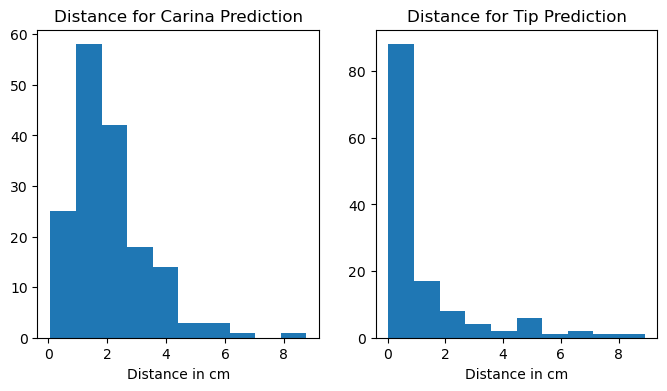

In [21]:
gt, max_score = get_dis_report(gt_file='/home/ec2-user/segmenter/MAIDA/data1000/test_annotations.json', 
               pred_file='/home/ec2-user/segmenter/InternImage/detection/mask_rcnn_test-dev_results_3cls.bbox.json')

Precision:  0.9411764705882353
Recall:  0.8533333333333334
F1 score:  0.8951048951048952
+--------+-------+----------+
|        |   Tip |   No Tip |
+========+=======+==========+
| Tip    |   128 |        8 |
+--------+-------+----------+
| No Tip |    22 |        8 |
+--------+-------+----------+
Max carina distance:  8.789670434894099
Min carina distance:  0.14446180731804636
Mean carina distance:  2.444492874345645
Std carina distance:  1.4444413786734351
Median carina distance:  2.0917932672896073
Max tip distance:  8.139406443478869
Min tip distance:  0.052974075519260366
Mean tip distance:  1.0778147363110993
Std tip distance:  1.5307476931642985
Median tip distance:  0.5849116105769515


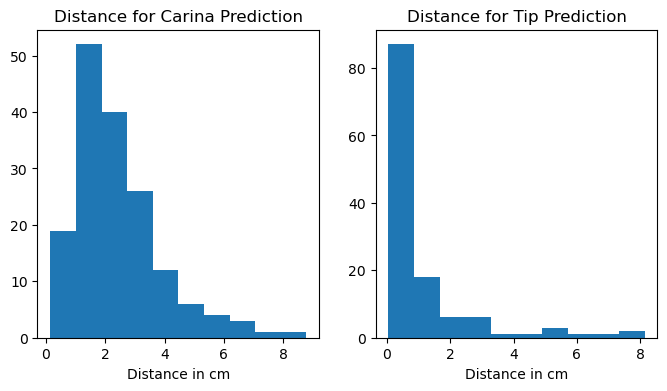

In [22]:
gt, max_score = get_dis_report(gt_file='/home/ec2-user/segmenter/MAIDA/data1000/test_annotations_4cls.json', 
               pred_file='/home/ec2-user/segmenter/InternImage/detection/mask_rcnn_test-dev_results_4cls.bbox.json')